# Cluster Grocery
### Description
Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.

However, they now have a lot of data about user purchase history. They want to do:

* The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to sent the ID of the following customers to the founder:
  * The customer who bought the most items overall in her lifetime
  * for each item, the customer who bought that product the most
* Cluster items based on user co-purchase history. That is, create cluster of products that have the highest probability of being bought together. The goal is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 1.Load dataset & Statistical Check

In [2]:
item_df = pd.read_csv('C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\ClusterGrocery\\item_to_id.csv', header = 0)
purchase_history_df = pd.read_csv('C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\ClusterGrocery\\purchase_history.csv', header = 0)

In [3]:
print(item_df.shape[0])
item_df.head()

48


,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [7]:
print(purchase_history_df.shape[0])
print('How many user', len(purchase_history_df.user_id.unique()))
purchase_history_df.head()
#There are 14589 duplicated user, which means this purchase_history dataset is time
#related in certain period of time, not cumulative. We may can get which customer has most
#purchase times, and which bought the most items.

39474
How many user 24885


,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [12]:
purchase_history_df[purchase_history_df.user_id==31625]

,user_id,id
8,31625,"1,43,31,37,25,32,28,35"
79,31625,"10,44,3,1,2,8,5,27,37"
7699,31625,"46,1,19,9,22,48,44,2,10,30,6,47,42"
12035,31625,"20,9,2,19,29,1"
21674,31625,"37,35,19,40,46"
25501,31625,"45,44,2,43"
26966,31625,"2,23,46,25,45,22,29,44,42"


In [35]:
purchase_history_df.groupby('user_id')['id'].agg('count').sort_values(ascending = False).head(10)

user_id
696000     7
884172     7
31625      7
653800     7
315516     6
813270     6
1271578    6
946453     6
920002     6
599172     6
Name: id, dtype: int64

In [3]:
user_item = purchase_history_df.groupby('user_id')['id'].apply(','.join).to_frame()
user_item = user_item.rename(columns ={'id':'item_id'})

In [4]:
def split_item(row):
    return(len(row['item_id'].split(',')))

In [7]:
len(user_item.item_id.loc[1478520].split(','))


7

In [5]:
user_item['item_count'] = user_item.apply(split_item, axis = 1)

In [6]:
user_item.head(8)

,item_id,item_count
user_id,,
47,"3,4,2,13,44,16,24,28,23,45,15,46,25",13
68,"23,10,42,39,19,6,17,25",8
113,"46,33,30,32,43,9,38,21,15,3,25",11
123,"4,10,27,18",4
223,"1,6,35,29,41,45,32,17,2,22,38",11
281,"35,3,13,39,34,42,44,33,21",9
323,"23,38,43,47,6,44,42,1,22,48,14,26,9,18,45",15
394,"39,2,1,31,41,43,38,46,28,10",10


**Notice the user_item dataset is the total item purchased by each customer, which means there are duplicated items since one customer could buy same items in different orders**
### Create user_item matrix

In [7]:
def item_by_user(df):
    all_item_ids = df['id'].str.split(',').sum()
    return pd.Series(Counter(int(id) for id in all_item_ids))

In [8]:
item_user_matrix = purchase_history_df.groupby('user_id').apply(item_by_user).unstack(fill_value = 0)

In [9]:
print(item_user_matrix.shape)
item_user_matrix.sample(8)

(24885, 48)


,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
1044870,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
184313,1,1,0,0,0,2,0,0,2,1,...,1,1,0,0,1,1,0,1,0,0
1388488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1304600,1,1,1,0,1,1,0,1,0,0,...,1,0,0,2,1,1,0,1,1,1
277066,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
895258,0,1,0,1,0,0,0,1,1,0,...,0,1,0,0,1,1,1,1,0,0
1475840,2,1,1,0,0,1,0,0,1,1,...,0,1,0,0,1,0,1,0,0,1
443021,1,1,2,0,0,1,0,1,1,0,...,0,1,0,1,1,0,1,1,0,0


In [6]:
item_user_matrix2 = item_user_matrix.copy()
item_user_matrix2['item_count'] = item_user_matrix2.sum(axis =1)

In [7]:
item_user_matrix2.head(8)

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,item_count
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,13
68,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,8
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,11
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
223,1,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,11
281,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,9
323,1,0,0,0,0,1,0,0,1,0,...,0,0,1,1,1,1,0,1,1,15
394,1,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,10


Both data frame(item_user_matrix, user_item) will give us what we want.
### 2. Customer who bought the most items overall in this period

In [8]:
print('The customer_id who bought most items is: {}, with {} unique items'.format(item_user_matrix2.item_count.idxmax(), \
                                                                     item_user_matrix2.item_count.max()))

The customer_id who bought most items is: 269335, with 72 unique items


### 3. For each item, which customer bought it most

In [12]:
item_countbyuser = item_df.copy()
item_countbyuser = item_countbyuser.set_index('Item_id')
item_countbyuser = item_countbyuser.sort_index()

In [13]:
item_countbyuser['max_user'] = item_user_matrix.idxmax(axis =0)
item_countbyuser['max_count'] =  item_user_matrix.max(axis =0)

In [14]:
item_countbyuser

,Item_name,max_user,max_count
Item_id,,,
1,sugar,31625,4
2,lettuce,31625,5
3,pet items,154960,4
4,baby items,5289,3
5,waffles,217277,3
6,poultry,334664,4
7,sandwich bags,175865,3
8,butter,151926,3
9,soda,269335,4


### 4. Item_item co-purchase matrix

In [10]:
M = normalize(item_user_matrix.values, axis = 0)
M

array([[0.        , 0.00708721, 0.01084015, ..., 0.00958222, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01084015, ..., 0.00958222, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.01084015, ..., 0.        , 0.        ,
        0.01247178],
       [0.00943942, 0.01417442, 0.        , ..., 0.        , 0.00970006,
        0.01247178],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [15]:
item_item_matrix = M.T.dot(M)
item_item_matrix = pd.DataFrame(item_item_matrix, index = item_countbyuser.index, \
                               columns =item_countbyuser.index)

In [16]:
item_item_matrix

Item_id,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Item_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269
6,0.388250,0.468199,0.358326,0.247414,0.233618,1.000000,0.267042,0.326704,0.385393,0.376518,...,0.376262,0.381924,0.338488,0.387834,0.382688,0.381860,0.390638,0.380686,0.496062,0.321075
7,0.271743,0.312200,0.238133,0.166012,0.164699,0.267042,1.000000,0.219365,0.256647,0.250765,...,0.249702,0.255744,0.229961,0.265111,0.250892,0.254311,0.255302,0.253011,0.253393,0.209766
8,0.335303,0.390521,0.301868,0.216166,0.203245,0.326704,0.219365,1.000000,0.319041,0.338472,...,0.320496,0.323186,0.279745,0.333141,0.313641,0.323224,0.327157,0.319095,0.320625,0.357460
9,0.403690,0.464872,0.362091,0.252662,0.239445,0.385393,0.256647,0.319041,1.000000,0.381207,...,0.375891,0.386393,0.334481,0.380174,0.486471,0.378158,0.376156,0.387666,0.380764,0.311454


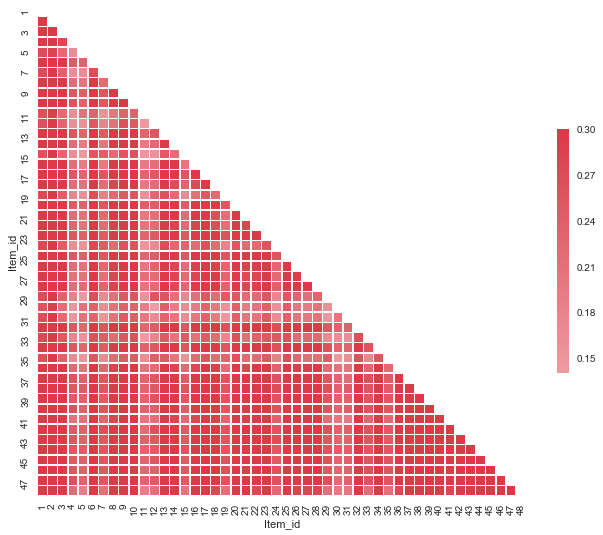

In [24]:
#Plot the heatmap
import seaborn as sns
sns.set(style="white")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(item_item_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(item_item_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The heatmap could tell us some userful information about the relationship between items, so using clustering algorithm to cluster items based on user purchase history.
### 5. Clustering
#### 5.1 PCA

In [27]:
#what is n for the n_components?
pca = PCA()
items_rotated = pca.fit_transform(item_item_matrix)
items_rotated = pd.DataFrame(items_rotated, index = item_countbyuser.index, \
                            columns = ['pc{}'.format(index+1) for index in range(48)])
items_rotated

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48
Item_id,,,,,,,,,,,,,,,,,,,,,
1,0.355639,-0.025103,-0.051129,-0.039214,-0.049529,0.003300,0.019830,-0.011458,0.084798,-0.042284,...,-0.019760,-0.012837,-0.006332,-0.022289,-0.002654,-0.001332,0.011263,-0.026911,-0.129284,8.204259e-17
2,0.793894,-0.041103,0.013244,-0.009035,-0.141627,-0.036540,-0.114816,-0.087070,0.000959,-0.035030,...,-0.039028,-0.015895,-0.027280,0.017406,0.013680,0.004437,-0.030161,0.006713,0.379136,8.204259e-17
3,0.135668,-0.029584,-0.028246,-0.012556,-0.013317,0.004220,-0.020503,-0.050246,0.177599,-0.080864,...,0.020455,-0.007168,0.040652,0.004387,0.029288,0.000224,0.009908,0.001288,-0.035429,8.204259e-17
4,-0.532034,0.020259,-0.022628,-0.037650,0.022756,-0.046219,0.042124,-0.132828,0.651482,-0.274771,...,0.000133,0.002444,0.005894,-0.003617,-0.005383,0.001555,-0.006114,0.007527,0.020217,8.204259e-17
5,-0.678770,-0.093874,-0.347623,-0.232866,-0.090366,-0.057124,-0.018074,0.038866,-0.048059,-0.014378,...,-0.008466,0.011890,0.002598,0.007605,0.009321,-0.003278,0.006540,0.000677,0.023603,8.204259e-17
6,0.312811,-0.036128,0.044851,0.017309,-0.035048,0.080819,-0.047894,-0.021530,0.119243,0.409097,...,-0.020227,0.037458,-0.003532,-0.068856,0.111363,0.038920,-0.179474,0.195229,-0.039911,8.204259e-17
7,-0.550273,-0.188354,0.058120,0.381101,-0.032518,-0.001882,-0.036626,-0.035533,-0.078704,0.033615,...,-0.003264,0.000230,-0.004935,0.009531,0.007640,0.003959,0.010467,0.000722,0.013446,8.204259e-17
8,-0.052373,0.402611,-0.084719,0.101044,0.061785,0.033619,-0.072494,-0.017836,-0.039679,0.006366,...,0.005499,-0.024467,-0.008533,-0.014347,0.004348,-0.003086,0.009040,-0.013534,-0.003083,8.204259e-17
9,0.337225,-0.088904,-0.039285,-0.046014,-0.062167,0.323283,0.195053,-0.089987,-0.061351,-0.085907,...,0.005030,0.248475,0.074118,-0.045950,-0.022483,-0.111802,-0.022843,-0.095708,0.006773,8.204259e-17


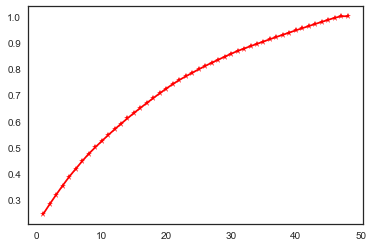

In [30]:
#show the total variance which can be explained by first K principle components
explained_var_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(explained_var_by_k)+1), explained_var_by_k, marker = "*", color = 'red')

In [42]:
#show the cluster result
def show_clusters(rotated_table, labels):
#     fig = plt.figure(figsize = (12,12))
#     colors = itertools.cycle(['b', 'g', 'r', 'c'])
    
    group_labels = rotated_table.groupby(labels)
    for label, grl in group_labels:
        #plt.scatter(grl.pc1, grl.pc2, c = next(colors), label = label)
        
        print('*******Label [{}]**********'.format(label))
        names = item_df.loc[grl.index, 'Item_name']
        for index, name in enumerate(names):
            print('\t<{}> {}'.format(index+1, name))
    #annotate
#     for item_i in rotated_table.index:
#         x = rotated_table.loc[item_i, 'pc1']
#         y = rotated_table.loc[item_i, 'pc2']
#         name = item_df.loc[item_i, 'Item_name']
#         name = re.sub('\W', ' ', name)
#         plt.text(x, y, name)


In [43]:
import itertools
def cluster(n):
    #using KMeans cluster algorithm to figure out how to cluster(K=?)
    kmeans = KMeans(n_clusters = n)
    kmeans.fit(item_item_matrix.values[:,:48])
    
    #show the result
    show_clusters(item_item_matrix, kmeans.labels_)

In [25]:
# K=?
#1.using elbow method to find the best k, which k gives the most obvious angle(just like elbow!)
#2.silhouette method: which k gives the largest silhouette value?
inertias = []
silhouettes = []

k_list = range(3,30)
for k in k_list:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(item_item_matrix)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(item_item_matrix, kmeans.predict(item_item_matrix)))
    

Text(0.5,1,'Silhouette score')

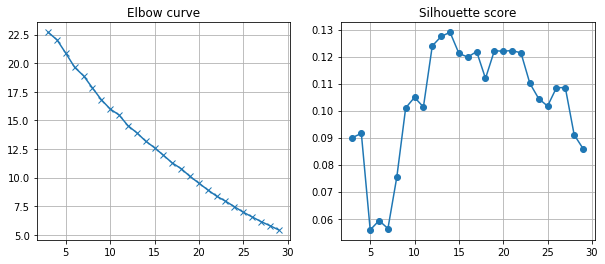

In [26]:
fig = plt.figure(figsize = (10,4))
fig.add_subplot(1,2,1)
plt.plot(k_list, inertias, marker = 'x')
plt.grid(True)
plt.title('Elbow curve')

fig.add_subplot(1,2,2)
plt.plot(k_list, silhouettes, marker = 'o')
plt.grid(True)
plt.title('Silhouette score')

From the elbow method, we can not find the 'elbow' point, but from silhouette score plot, we can find the largest score is when k = 14.

In [44]:
cluster(n=14)

*******Label [0]**********
	<1> dinner rolls
	<2> cheeses
	<3> apples
	<4> broccoli
*******Label [1]**********
	<1> tea
	<2> soda
	<3> tortillas
	<4> flour
	<5> pet items
*******Label [2]**********
	<1> butter
	<2> beef
	<3> cauliflower
*******Label [3]**********
	<1> eggs
	<2> pasta
	<3> grapefruit
	<4> lettuce
*******Label [4]**********
	<1> canned vegetables
	<2> yogurt
	<3> cereals
	<4> frozen vegetables
	<5> nan
*******Label [5]**********
	<1> waffles
	<2> pork
	<3> carrots
	<4> aluminum foil
	<5> baby items
*******Label [6]**********
	<1> ice cream
	<2> laundry detergent
*******Label [7]**********
	<1> sandwich loaves
*******Label [8]**********
	<1> spaghetti sauce
	<2> poultry
	<3> paper towels
	<4> soap
*******Label [9]**********
	<1> juice
	<2> ketchup
	<3> shampoo
	<4> hand soap
	<5> shaving cream
*******Label [10]**********
	<1> bagels
*******Label [11]**********
	<1> sugar
	<2> berries
*******Label [12]**********
	<1> milk
	<2> cucumbers
	<3> dishwashing 
	<4> toilet paper


c:\users\tianyi fang\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
